<a href="https://colab.research.google.com/github/AlexBorealis/netology_tsml_hw/blob/master/kozlov_tsml_hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 12.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [3]:
series = pd.read_csv("monthly-boston-armed-robberies-j.csv")['Count']

def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    dfoutput = dfoutput.to_frame().reset_index()
    dfoutput.columns = ['parameters', 'value']
    return dfoutput

def tsplot(y, lags= None, figsize= (12, 6), style= 'bmh', plot_name= None):
    print(test_stationarity(y))
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan= 2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax= ts_ax, color= 'blue', label= 'Or')
        ts_ax.set_title(plot_name)

        smt.graphics.plot_acf(y, lags= lags, ax= acf_ax, alpha= .05)
        smt.graphics.plot_pacf(y, lags= lags, ax= pacf_ax, alpha= .05)
        sm.qqplot(y, line= 's', ax= qq_ax)

        plt.tight_layout()
    return fig

                    parameters       value
0               Test Statistic    1.001102
1                      p-value    0.994278
2                    Lags Used   11.000000
3  Number of Observations Used  106.000000
4          Critical Value (1%)   -3.493602
5          Critical Value (5%)   -2.889217
6         Critical Value (10%)   -2.581533


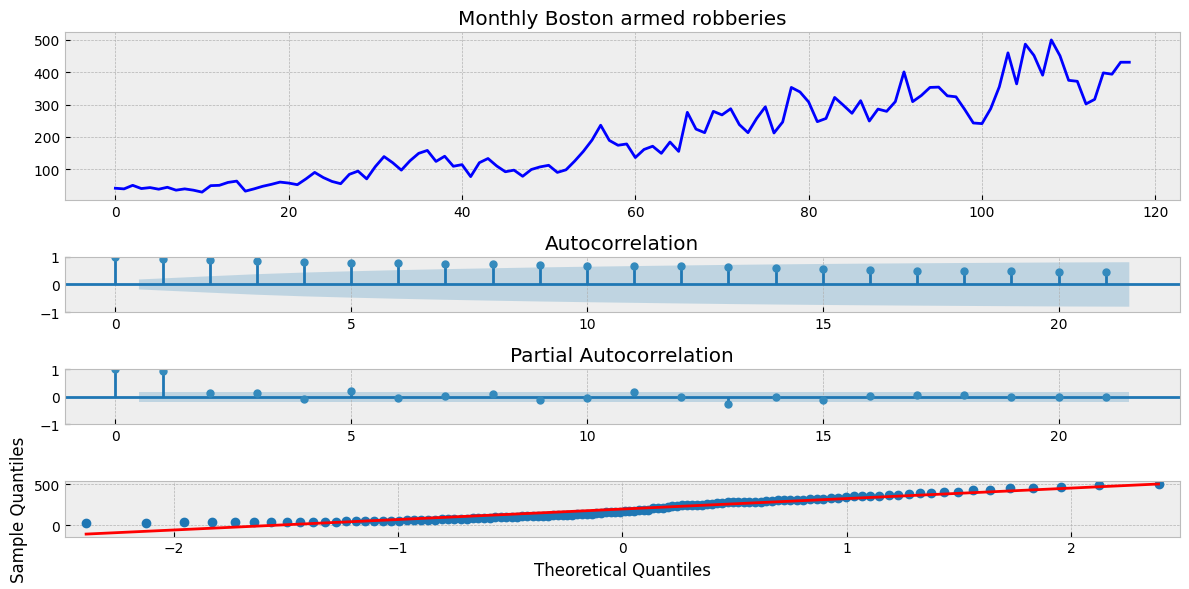

In [4]:
init_plot = tsplot(series, plot_name= 'Monthly Boston armed robberies')

                    parameters       value
0               Test Statistic   -0.876346
1                      p-value    0.795662
2                    Lags Used   11.000000
3  Number of Observations Used  106.000000
4          Critical Value (1%)   -3.493602
5          Critical Value (5%)   -2.889217
6         Critical Value (10%)   -2.581533


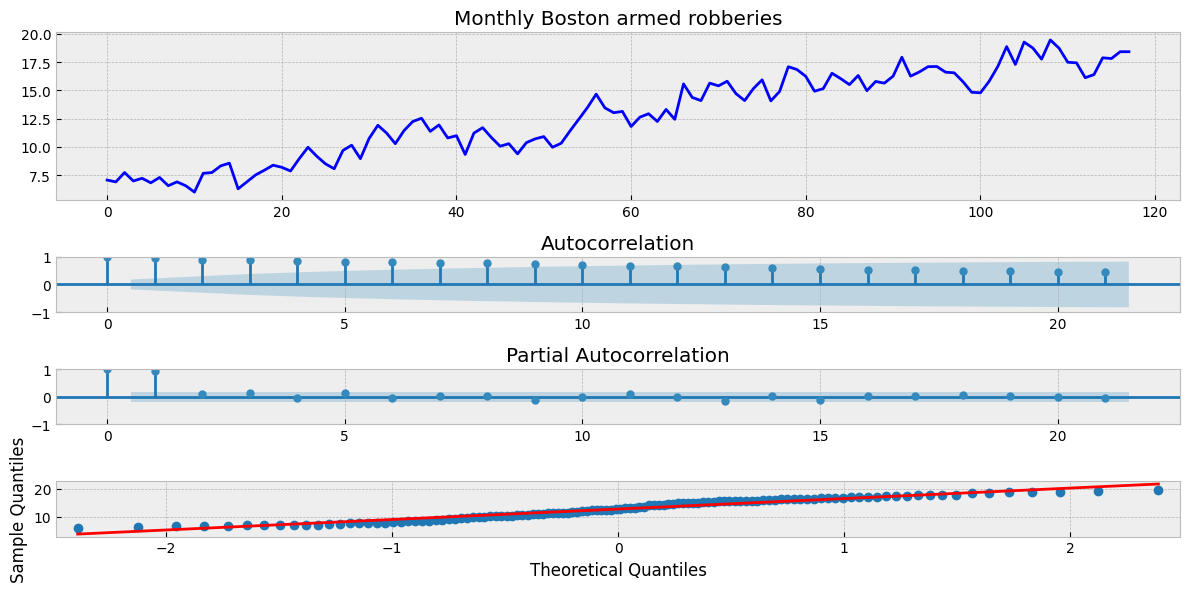

In [10]:
new_series = boxcox(series)
new_series_plot = tsplot(new_series[0], plot_name= 'Monthly Boston armed robberies')

In [11]:
import warnings
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None
best_season = None
best_mdl = None

for p in range(5):
    for d in range(1, 5):
        for q in range(5):
            for s in range(3):
                try:
                    tmp_mdl = smt.ARIMA(new_series[0],
                                        order= (p, d, q),
                                        seasonal_order= (0, 0, 0, s),
                                        trend= 't').fit(method= 'innovations_mle')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, q)
                        best_season = s
                        best_mdl = tmp_mdl
                except: continue

In [26]:
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

am = arch_model(new_series[0], p= p_, o= o_, q= q_, dist= 'StudentsT')
res = am.fit(update_freq= 5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 303.93946057257494
Iteration:     10,   Func. Count:     79,   Neg. LLF: 303.71076381653023
Iteration:     15,   Func. Count:    116,   Neg. LLF: 301.73456356013713
Iteration:     20,   Func. Count:    155,   Neg. LLF: 300.77053012438387
Iteration:     25,   Func. Count:    190,   Neg. LLF: 300.1116362111249
Iteration:     30,   Func. Count:    226,   Neg. LLF: 558.3616855556749
Optimization terminated successfully    (Exit mode 0)
            Current function value: 299.9232949665031
            Iterations: 30
            Function evaluations: 236
            Gradient evaluations: 30
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -299.923
Distribution: 

In [117]:
res.model

Constant Mean(constant: yes, no. of exog: 0, volatility: GJR-GARCH(p: 1, o: 1, q: 1), distribution: Standardized Student's t distribution), id: 0x7892c4392da0

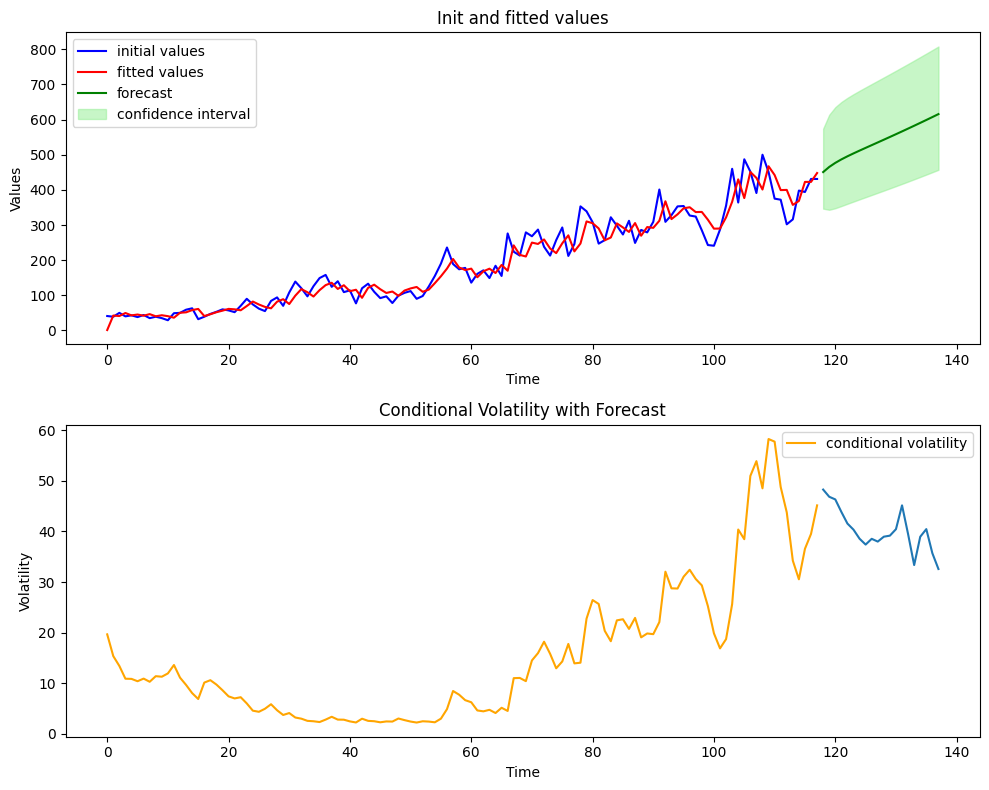

In [109]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 1st graph
forecast = best_mdl.get_forecast(steps= 20)
forecast_index = np.arange(len(series), len(series) + 20)

forecast_fitted = (best_mdl.fittedvalues * new_series[1] + 1) ** (1 / new_series[1])
forecast_values = (forecast.predicted_mean * new_series[1] + 1) ** (1 / new_series[1])

conf_int_boxcox = forecast.conf_int()
conf_int_original = ((conf_int_boxcox * new_series[1] + 1) ** (1 / new_series[1]))

ax1.plot(series, color= 'blue', label= 'initial values')
ax1.plot(forecast_fitted, color= 'red', label= 'fitted values')
ax1.plot(forecast_index, forecast_values, color= 'green', label= 'forecast')

ax1.fill_between(forecast_index,
                 conf_int_original[:, 0],
                 conf_int_original[:, 1],
                 color= 'lightgreen', alpha= .5, label= 'confidence interval')
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.legend()
ax1.set_title('Init and fitted values')

# 2nd graph
volatility = (res.conditional_volatility * new_series[1] + 1) ** (1 / new_series[1])
rng = np.random.default_rng(42)
forecast_volatility = np.sqrt(res.forecast(horizon= 20, method= 'simulation', rng= rng.standard_normal).variance.values)[0]

volatility_forecast = (forecast_volatility * new_series[1] + 1) ** (1 / new_series[1])

ax2.plot(volatility, label= 'conditional volatility', color= 'orange')
ax2.plot(np.arange(len(volatility), len(volatility) + 20), volatility_forecast)
ax2.plot()

ax2.set_xlabel('Time')
ax2.set_ylabel('Volatility')
ax2.set_title('Conditional Volatility with Forecast')
ax2.legend()

plt.tight_layout()
plt.show()

Результаты GJR-GARCH модели, которые вы привели, содержат несколько ключевых компонентов, которые помогают понять, как модель работает и какие параметры были оценены. Давайте разберем их по частям.

### Общая информация о модели

- **Dep. Variable**: Это зависимая переменная, которую вы моделируете. В данном случае это обозначено как y.

- **Mean Model**: Указывает, что используется постоянная средняя (Constant Mean) для модели.

- **Vol Model**: Указывает, что используется модель GJR-GARCH для оценки волатильности.

- **Log-Likelihood**: Значение логарифмической функции правдоподобия. Чем выше это значение, тем лучше модель описывает данные.

- **AIC и BIC**: Это критерии информационного критерия Акаике (AIC) и байесовского информационного критерия (BIC). Они используются для сравнения моделей: более низкие значения указывают на лучшую модель.

### Результаты модели

### Mean Model (Средняя модель)

- **mu**: Это оценка постоянной средней. В данном случае значение 11.0687 с стандартной ошибкой 0.615. Это означает, что среднее значение временного ряда, который вы анализируете, составляет примерно 11.07. Высокое значение t-статистики (18.007) и низкое p-значение (1.709e-72) указывают на то, что это значение статистически значимо.

### Volatility Model (Модель волатильности)

- **omega**: Это константа в модели GJR-GARCH, которая отвечает за уровень базовой волатильности. Значение 0.2658 с стандартной ошибкой 0.307 указывает на результаты GJR-GARCH модели, которые вы привели, содержат несколько ключевых компонентов, которые помогают понять, как модель работает и какие параметры были оценены. Давайте разберем их по частям.

### Результаты модели

### Mean Model (Средняя модель)

- **mu**: Это оценка постоянной средней. В данном случае значение 11.0687 указывает на то, что среднее значение временного ряда составляет примерно 11.07. Стандартная ошибка (std err) равна 0.615, что указывает на надежность этой оценки. Значение t-статистики (t) равно 18.007, что говорит о том, что это значение статистически значимо (p-значение ### Volatility Model (Модель волатильности)

- **omega**: Это параметр, который представляет собой постоянную в уравнении волатильности. Значение 0.2658 с стандартной ошибкой 0.307 указывает на то, что этот параметр не является статистически значимым (p-значение > 0.05).

- **alpha[1]**: Это коэффициент, который показывает влияние прошлых ошибок (шоков) на текущую волатильность. Значение 0.5234 с p-значением 5.610e-02 (приблизительно 0.056) указывает на то, что этот параметр близок к статистической значимости, что говорит о том, что прошлые шоки имеют влияние на текущую волатильность.

- **gamma[1]**: Это параметр, который учитывает асимметричное влияние отрицательных шоков на волатильность. Значение -0.1892 с p-значением 1.658e-02 (приблизительно 0.017) указывает на то, что отрицательные шоки имеют значительное влияние на волатильность, что является характерной чертой GJR-GARCH моделей.

- **beta[1]**: Это коэффициент, который показывает влияние прошлой волатильности на текущую волатильность. Значение 0.5415 с p-значением 3.611e-02 (приблизительно 0.036) указывает на то, что прошлые значения волатильности также имеют значительное влияние на текущую волатильность.

### Distribution (Распределение)

- **nu**: Это параметр, который указывает на степень свободы распределения ошибок. Значение 380.7290 с p-значением 2.346e-65 (очень малое значение) указывает на то, что это значение статистически значимо. Высокое значение nu указывает на то, что распределение ошибок близко к нормальному.

Библиотека arch в Python предоставляет инструменты для оценки моделей временных рядов, особенно тех, которые связаны с условной гетероскедастичностью. Вот краткий обзор основных моделей, доступных в библиотеке arch, и объяснение их работы:

### 1. GARCH (Generalized Autoregressive Conditional Heteroskedasticity)

- **Описание**: Модель GARCH расширяет модель ARCH, позволяя учитывать не только прошлые ошибки, но и прошлую волатильность. Это позволяет лучше моделировать временные ряды с изменяющейся волатильностью.

- **Формула**:

  $$
  \sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
  $$
  где $\sigma_t^2$ — условная дисперсия, $\epsilon_{t-1}$ — ошибка в предыдущий момент времени, а $\alpha_0$, $\alpha_1$ и $\beta_1$ — параметры модели.

### 2. EGARCH (Exponential GARCH)

- **Описание**: Модель EGARCH позволяет моделировать асимметричное влияние положительных и отрицательных шоков на волатильность. Это означает, что отрицательные шоки могут иметь больший эффект на волатильность, чем положительные.

- **Формула**:

  $$
  \log(\sigma_t^2) = \alpha_0 + \sum_{i=1}^{p} \alpha_i \frac{\epsilon_{t-i}}{\sigma_{t-i}} + \sum_{j=1}^{q} \beta_j \log(\sigma_{t-j}^2)
  $$

### 3. GJR-GARCH (Glosten-Jagannathan-Runkle GARCH)

- **Описание**: Модель GJR-GARCH также учитывает асимметричное влияние шоков на волатильность, но делает это через добавление дополнительного параметра для отрицательных шоков.

- **Формула**:

  $$
  \sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2 + \gamma I(\epsilon_{t-1})
  $$
  
### 4. APARCH (Asymmetric Power ARCH)

- **Описание**: Модель APARCH позволяет моделировать волатильность с учетом асимметрии и различных степеней влияния шоков. Она может использоваться для анализа временных рядов с различными распределениями ошибок.

- **Формула**:

  $$
  \sigma_t^d = \alpha_0 + \sum_{i=1}^{p} \alpha_i |\epsilon_{t-i}|^d + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^d
  $$

### 5. HARCH (Heterogeneous ARCH)

- **Описание**: Модель HARCH позволяет учитывать волатильность на разных временных интервалах, что может быть полезно для анализа временных рядов с различными временными масштабами.

- **Формула**:

  $$
  \sigma_t^2 = \alpha_0 + \sum_{i=1}^{p} \alpha_i \sigma_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
  $$

### Как они работают

Все эти модели работают на основе предположения, что волатильность временного ряда изменяется со временем и может быть предсказана на основе прошлых значений. Они используют методы максимального правдоподобия для оценки параметров и могут быть применены к различным типам данных, включая финансовые временные ряды.